#`This Notebook Is An Illustration to Create a Custom Dataset for Sentiment Analysis.`
<img src="https://nycdsa-blog-files.s3.us-east-2.amazonaws.com/2019/09/nexus2cee_Default_Google_Play_Hero_since_we_dont_have_one_1_728x410.0.png-1024x683.jpeg" alt="Simply Easy Learning" width="185"
         height="130">

For more information, check out the [Google Play Scraper](https://github.com/JoMingyu/google-play-scraper).








## **Setup**
Install the required packages and setup the imports:

In [1]:
!pip install -qq google-play-scraper

     |████████████████████████████████| 51kB 1.6MB/s 


In [ ]:
import json
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

from google_play_scraper import Sort, reviews, app

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.4) 


Google Play has plenty of apps, reviews, and scores. We can scrape app info and reviews using the [google-play-scraper](https://github.com/JoMingyu/google-play-scraper) package.

Let's choose some apps that fit the criteria from the *Productivity* category. They contain both positive and negative reviews which can reduces the uncertainity(imbalance) in our dataset.

<img src="https://s3.amazonaws.com/chartboost/help_assets/GooglePlay-BundleID.png" alt="Simply Easy Learning" width="580"
         height="245">

## **A list of ID's from URL**

In [3]:
app_packages = [
  'com.anydo',
  'com.todoist',
  'com.ticktick.task',
  'com.habitrpg.android.habitica',
  'cc.forestapp',
  'com.oristats.habitbull',
  'com.levor.liferpgtasks',
  'com.habitnow',
  'com.microsoft.todos',
  'prox.lab.calclock',
  'com.gmail.jmartindev.timetune',
  'com.artfulagenda.app',
  'com.tasks.android',
  'com.appgenix.bizcal',
  'com.appxy.planner',
  'com.boostedproductivity.app',
  'app.glan',
  'com.pomodrone.app',
  'com.superelement.pomodoro',
  'kr.co.rinasoft.yktime'
]

## **Scraping App Information**

Let's scrape the info for each app:

In [4]:
app_infos = []

for apps in tqdm(app_packages):
  info = app(apps, lang='en', country='us')
  del info['comments']
  app_infos.append(info)

100%|██████████| 20/20 [00:03<00:00,  5.18it/s]


We got the info for all 20 apps.

 A function that prints JSON objects a bit better:

In [5]:
def print_json(json_object):
  json_str = json.dumps(
    json_object, 
    indent=2, 
    sort_keys=True, 
    default=str
  )
  print(highlight(json_str, JsonLexer(), TerminalFormatter()))

In [6]:
print_json(app_infos[0])

{
  "adSupported": null,
  "androidVersion": "Varies",
  "androidVersionText": "Varies with device",
  "appId": "com.anydo",
  "containsAds": null,
  "contentRating": "Everyone",
  "contentRatingDescription": null,
  "currency": "USD",
  "description": "<b>\ud83c\udfc6 Editor's Choice by Google</b>\r\n\r\nAny.do is a To Do List, Calendar, Planner, Tasks & Reminders App That Helps Over 25M People Stay Organized and Get More Done.\r\n\r\n<b>\ud83e\udd47 \"A MUST HAVE APP\" (Lifehacker, NYTimes, USA TODAY, WSJ).</b>\r\n\r\nAny.do is a free to-do list, planner & calendar app for managing and organizing your daily tasks, to-do lists, notes, reminders, checklists, calendar events, grocery lists and more.\r\n\r\n\ud83d\udcc5 Organize Your Tasks & To-Do List in Seconds\r\n\r\n\u2022 ADVANCED CALENDAR & DAILY PLANNER - Keep your to-do list and calendar events always at hand with our calendar widget. Any.do to-do list & planner support daily calendar view, 3-day Calendar view, Weekly calendar vi

This contains lots of information including the number of ratings, number of reviews and number of ratings for each score (1 to 5).

## **App Icon Visualization**
Let's ignore all of that and have a look at their icons:


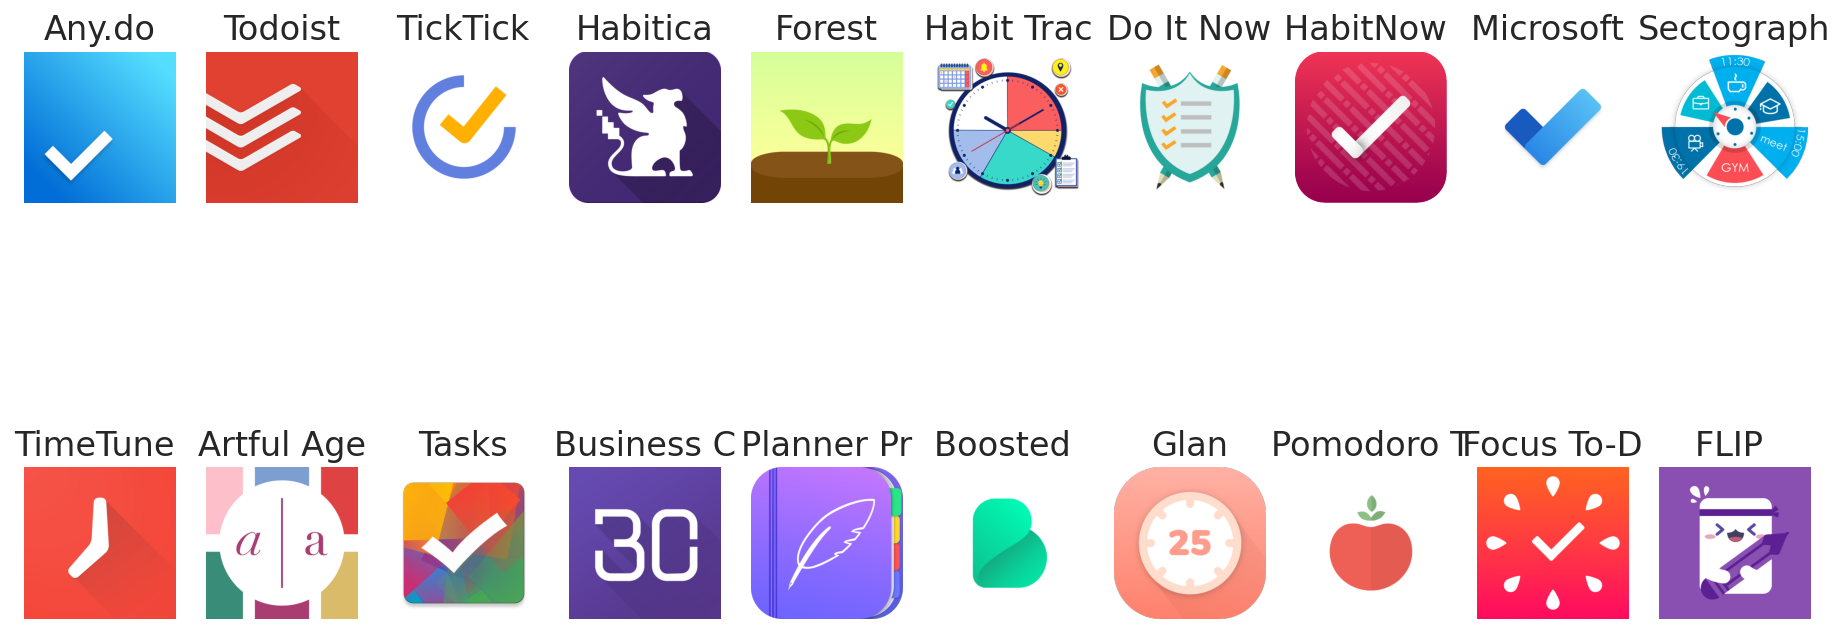

In [7]:
def format_title(title):
  sep_index = title.find(':') if title.find(':') != -1 else title.find('-')
  if sep_index != -1:
    title = title[:sep_index]
  return title[:10]

fig, axs = plt.subplots(2, len(app_infos) // 2, figsize=(16, 7))

for i, ax in enumerate(axs.flat):
  ai = app_infos[i]
  img = plt.imread(ai['icon'])
  ax.imshow(img)
  ax.set_title(format_title(ai['title']))
  ax.axis('off')  

We'll store the app information for later by converting the JSON objects into a Pandas dataframe and saving the result into a CSV file:

In [8]:
app_infos_df = pd.DataFrame(app_infos)
app_infos_df.to_csv('apps.csv', index=None, header=True) 

## **Scraping App Reviews**

We want:

* Balanced dataset - roughly the same number of reviews for each score (1-5).
* We can satisfy the requirement by using the scraping package option to filter the review score. 

In [9]:
app_reviews = []

for ap in tqdm(app_packages):
  for score in list(range(1, 6)):
    for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
      rvs, _ = reviews(
        ap,
        lang='en',
        country='us',
        sort=sort_order,
        count= 200 if score == 3 else 100,
        filter_score_with=score
      )
      for r in rvs:
        r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
        r['appId'] = ap
      app_reviews.extend(rvs) 

100%|██████████| 20/20 [00:59<00:00,  3.00s/it]


In [10]:
print_json(app_reviews[0]) 

{
  "appId": "com.anydo",
  "at": "2020-07-22 07:23:35",
  "content": "OMG the UI is awful, seriously you have popup for premium every 2 seconds, there's no intuitive way see a normal calendar, you have to create an account even if you don't want to, the app is beautiful but show screen where it's impossible to understand what you have to do. It's a calendar, show a f... calendar.",
  "repliedAt": "2020-07-23 16:20:43",
  "replyContent": "The Premium ad only shows up when first opening the app, and when clicking on a Premium feature. To manage your Calendar View, click on the 3 lines icon on the top left (support.any.do/daily-calendar). Note that Any.do is account-based in order to sync and save all tasks on our servers, so all information is available 24/7 across all platforms.",
  "reviewCreatedVersion": "5.2.0.23",
  "reviewId": "gp:AOqpTOElISilniODwd6UBrqFngzTtDHLF-G0VLpR2_y1sV7IzvZ1DseLe4E2ZNiuQzrUc0To12jF9rMqIY0Fvg",
  "score": 1,
  "sortOrder": "most_relevant",
  "thumbsUpCount"

In [11]:
len(app_reviews) 

20084

Let's save the reviews to a CSV file:

In [12]:
app_reviews_df = pd.DataFrame(app_reviews)
app_reviews_df.to_csv('reviews(20APPS).csv', index=None, header=True) 

## **Summary**
You now have a dataset with more than 20k user reviews from 20 productivity apps. Of course, you can go crazy and get much much more.

You now have learned to: 
* Set goals and expectations for your dataset
* Scrape Google Play app information
* Scrape user reviews for Google Play apps
* Save the dataset to CSV files

#### References 
* [Google Play Scraper for python](https://github.com/JoMingyu/google-play-scraper)
